## Library Imports

In [ ]:
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from PIL import Image
import os
import random
from IPython.display import display
import matplotlib.pyplot as plt

## Image Matrix Construction

In [ ]:
file_dict = {} # dictionary to hold path to each image (for reduced space & faster access time)

def create_vec(location, count_of_same_celebrity=40):
    '''
    Create a random vectorized array with 'n' number of images of each celebrity

    location: location of the master folder
    count_of_same_celebrity: number of random images taken of the same celebrity
    '''
    # Create an empty list to store arrays
    img_arrays = []
    global file_dict

    idx = 0

    for celeb in os.listdir(location):
        celeb_path = os.path.join(location, celeb)
        if not os.path.isdir(celeb_path):
            continue  # Skip if the item in the directory is not a folder

        files = [f for f in os.listdir(celeb_path) if os.path.isfile(os.path.join(celeb_path, f))]

        # Use min() to avoid going beyond the available indices
        selected_files = random.sample(files, min(len(files), count_of_same_celebrity))

        for selected_file in selected_files:
            face_path = os.path.join(celeb_path, selected_file)
            file_dict[idx] = face_path
            idx+=1

            # Open and resize the face image
            face_image = Image.open(face_path).convert("L")  # Convert to grayscale
            resized_face_image = face_image.resize((20, 20))
            img_array = np.array(resized_face_image).flatten()
            img_arrays.append(img_array)

    # Convert the list of arrays into a NumPy array
    img_matrix = np.transpose(img_arrays)

    return img_matrix


B = create_vec('Cropped Celebrity Faces Dataset') # Path input to dataset folder

In [ ]:
n = B.shape[0]
m = B.shape[1]
print("n =", n)
print("m =", m)

n = 400
m = 680


In [ ]:
mean = np.mean(B, axis=1, keepdims=True)
A = B - mean

## Ren et al. Encryption

### Generation of X,Y,Z

In [ ]:
# Generate permutation matrices P1_perm, P2_perm, P3_perm
P1_perm = np.eye(n)[:, np.random.permutation(n)]
P2_perm = np.eye(m)[:, np.random.permutation(m)]
P3_perm = np.eye(m)[:, np.random.permutation(m)]

# Creation of random vectors
a = np.random.rand(P1_perm.shape[0],1)
b = np.random.rand(P2_perm.shape[0],1)
c = np.random.rand(P3_perm.shape[0],1)

# Generating P1, P2, P3 (Multiplying a,b,c with P1_perm,P2_perm,P3_perm respectively)
P1 = np.zeros_like(P1_perm)
for i in range(len(a)):
    P1[i,:] = P1_perm[i,:] * a[i]

P2 = np.zeros_like(P2_perm)
for i in range(len(b)):
    P2[i,:] = P2_perm[i,:] * b[i]

P3 = np.zeros_like(P3_perm)
for i in range(len(c)):
    P3[i,:] = P3_perm[i,:] * c[i]

X = P1 @ A @ np.linalg.inv(P2)
Y = P2 @ A.T @ P1.T
Z = np.linalg.inv(P1.T) @ A @ P3

# Creation of T matrix
T = np.dot(X, Y)

## Outsourcing to Cloud

In [ ]:
# Eigendecomposition
D, U = np.linalg.eig(T)

# Sort the eigen values
sorted_indices = np.argsort(D)[::-1]
U_sorted = U[:, sorted_indices]

# Reducing the total number of eigenfaces to be considered
num_components = 100    # User input
U_reduced = U_sorted[:, :num_components]
W = np.dot(U_reduced.T, Z)

# Generate the diagonal eigenvalue matrix
D1 = np.diag(D)

# Decryption

In [ ]:
# Reduced Dimension matrix
Y1 = W @ np.linalg.inv(P3)

## Verification

In [ ]:
A_bar = np.linalg.inv(P1) @ U
A_tilde = (np.linalg.inv(P1) @ U_reduced).T


l=int(input('No. of trials= '))
# Step 1
for i in range(l):
    e = np.random.choice([0, 1], size=(A_bar.shape[0]))
    err = np.linalg.norm(A_bar @ (D1 @ (A_bar.T @ e)) - A @ (A.T @ e))

    if err >= 1e-4:
        print("Verification failed")
        break

else:
    print("Verification successful for all trials")

# Step 2
for i in range(l):
    e1 = np.random.choice([0, 1], size=(A.shape[1]))
    err1 = np.linalg.norm(A_tilde @ (A @ e1) - (Y1 @ e1))

    if err1 >= 1e-4:
        print("Verification failed")
        break

else:
    print("Verification successful for all trials")


No. of trials= 80
Verification successful for all trials
Verification successful for all trials


## Testing image

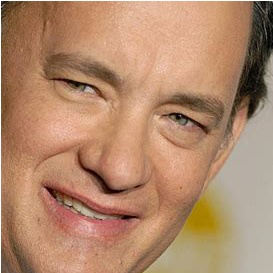

In [ ]:
def preprocess_test_image(file_path, target_size=(20, 20)):
    '''
    Preprocess the test image (present at 'file_path') according to the changes made in the train data for each image column
    '''
    img = Image.open(file_path).convert('L')  # Convert image to grayscale
    img_resized = img.resize(target_size, Image.LANCZOS)  # Resize image to a uniform size
    img_array = np.array(img_resized).flatten()  # Flatten the resized image to a single column vector
    return img_array

# Path to your test image file (replace with the actual path to your test image)
test_image_path = 'Test/Tom Hanks/008_74cd0628.jpg'  # Replace with your test image file path

img = Image.open(test_image_path)
display(img)

In [ ]:
# Load and preprocess the test image into a column vector
x = preprocess_test_image(test_image_path)

x_reshaped = x.reshape(-1,1)
x_reshaped.shape

# Normalizing
x_norm = x_reshaped - mean

# Transforming
x_trans = A_tilde @ x_norm

In [ ]:
# Find the closest training image to the test image
d = np.linalg.norm(x_trans - Y1, axis=0)
d_min = np.min(d)
d_index = np.argmin(d)

In [ ]:
from IPython.display import display

def display_original(n):
  '''
  n: a number less than A.shape[1] and the index of the image to be displayed
  '''
  global file_dict
  display(Image.open(file_dict[n]))

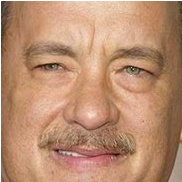

In [ ]:
display_original(d_index)

# Twisted (Cheating)

In [ ]:
k = np.random.randn(U.shape[0],1)*100
k1 = np.square(k)
D_twisted = np.zeros_like(D)
for i in range(len(D)):
    D_twisted[i] = D[i] / k1[i]
D1_twisted = np.diag(D_twisted)

U_twisted = np.zeros_like(U)
for i in range(len(k)):
    U_twisted[:, i] = U[:, i] * k[i]

twisted_indices = np.argsort(D_twisted)[::-1]
U_sorted_twisted = U_twisted[:, sorted_indices]

# Number of eigenfaces
num_components = 100 # same as before 
U_reduced_twisted = U_sorted_twisted[:, :num_components]
W_twisted = np.dot(U_reduced_twisted.T, Z)

# Incorrect Decryption

In [ ]:
# Reduced Dimension matrix
Y1_twisted = W_twisted @ np.linalg.inv(P3)

## Verification

In [ ]:
A_bar_twisted = np.linalg.inv(P1) @ U_twisted
A_tilde_twisted = (np.linalg.inv(P1) @ U_reduced_twisted).T


l=int(input('No. of trials= '))
#Step 1
for i in range(l):
    e3 = np.random.choice([0, 1], size=(A_bar_twisted.shape[0]))
    err3 = np.linalg.norm(A_bar_twisted @ (D1_twisted @ (A_bar_twisted.T @ e3)) - A @ (A.T @ e3))

    if err3 >= 1e-4:
        print("Verification failed")
        break

else:
    print("Verification successful for all trials")

#Step 2
for i in range(l):
    e4 = np.random.choice([0, 1], size=(A.shape[1]))
    err4 = np.linalg.norm(A_tilde_twisted @ (A @ e4) - (Y1_twisted @ e4))

    if err4 >= 1e-4:
        print("Verification failed")
        break

else:
    print("Verification successful for all trials")


No. of trials= 80
Verification successful for all trials
Verification successful for all trials


# Incorrect Recognition of Test Image

In [ ]:
# Twisted transformation of x
x_twisted = A_tilde_twisted @ x_norm

In [ ]:
d_new = np.linalg.norm(x_twisted - Y1_twisted, axis=0)
d_newmin = np.min(d_new)
d_newindex = np.argmin(d_new)

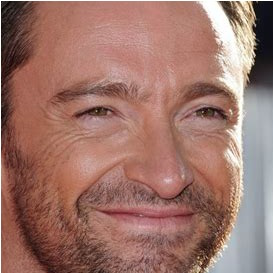

In [ ]:
display_original(d_newindex)